In [1]:
# Hyperparameters
BATCH_SIZE = 128    # for memory replay

GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

TAU = 0.005         # for soft update of target net
LR = 1e-4

In [2]:
# Environment
import gymnasium as gym

env = gym.make("CartPole-v1")

n_actions = env.action_space.n
print("n_actions:", n_actions)
state, info = env.reset()
n_observations = len(state)
print("n_observations:", n_observations)

n_actions: 2
n_observations: 4


In [3]:
from model import DQN

policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)     # fixed target
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [4]:
import torch

from memory import ReplayMemory, Transition

optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

In [5]:
import math
import random


steps_done = 0


def select_action(state):
    # state: [1, n_observations]
    # return [1, 1]

    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * (
        math.exp(-1.0 * steps_done / EPS_DECAY)
    )
    # eps = probability of exploration
    #   The agent explores less as the training proceeds

    steps_done += 1
    
    if sample > eps_threshold:
        # exploitation
        with torch.no_grad():
            return torch.max(
                policy_net(state), dim=-1
            ).indices.view(1, 1)
    else:
        # exploration
        return torch.tensor(
            [[env.action_space.sample()]],
            dtype=torch.long,
        )

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(batch_size=BATCH_SIZE)  # list of transitions
    batch = Transition(*zip(*transitions))
    # Each element of Transtion is now a list of BATCH_SIZE items

    state_batch = torch.cat(batch.state)    # [BATCH_SIZE, n_observations]
    action_batch = torch.cat(batch.action)  # [BATCH_SIZE, 1]
    reward_batch = torch.cat(batch.reward)  # [BATCH_SIZE]

    # Compute Q(s, a)
    #   The policy network returns Q(s),
    #   and then we choose the values corresponding to the given actions
    state_action_values = torch.gather(policy_net(state_batch), dim=1, index=action_batch)
    # [BATCH_SIZE, 1]

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        dtype=torch.bool,
    )
    non_final_next_state = torch.cat([s for s in batch.next_state if s is not None])
    # [BATCH_SIZE, n_observations]

    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = torch.max(
            target_net(non_final_next_state), dim=1
        ).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # target: R + gamma * max_a Q(s_{t+1}, a)

    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [7]:
import matplotlib.pyplot as plt
from IPython import display


episode_durations = []

def plot_durations(show_result: bool = False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())

    # Moving average of 100 episodes
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)    # Wait until plots are updated
    if show_result:
        display.display(plt.gcf())
    else:
        display.display(plt.gcf())
        display.clear_output(wait=True)

Complete


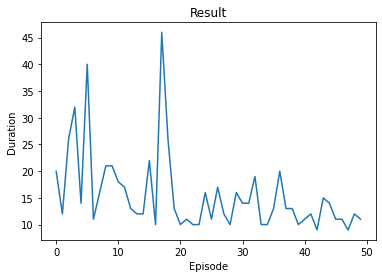

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
from itertools import count


num_episodes = 50

for i_episode in range(num_episodes):
    # Reset environment
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)   # [1, n_observations]

    for t in count():
        action = select_action(state)   # [1, 1]
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward])

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Store transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of optimization on the policy network
        optimize_model()

        # Soft update the target network's weights
        #   Alternatively, we can update the target network's weights every C steps
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = (
                policy_net_state_dict[key] * TAU
                + target_net_state_dict[key] * (1 - TAU)
            )
        target_net.load_state_dict(target_net_state_dict)

        if terminated or truncated:
            episode_durations.append(t + 1)
            plot_durations()
            break

print("Complete")
plot_durations(show_result=True)
plt.ioff()
plt.show()